## Prepare dataset

In [1]:
import pandas as pd
import numpy as np
import joblib
df = pd.read_parquet('trend_overlaid.pq')
print(df.shape)

(69, 605)


In [2]:
lithology = '''1	alkaliOlivineBasalt
2	amphibolite
3	andesite
4	anorthositicRock
5	arenite
6	ashBrecciaBombOrBlockTephra
7	ashTuffLapillistoneAndLapilliTuff
8	basalt
9	basanite
10	biogenicSilicaSedimentaryRock
11	breccia
12	brecciaGougeSeries
13	carbonateMud
14	carbonateOoze
15	carbonateSedimentaryRock
16	carbonatite
17	chalk
18	chloriteActinoliteEpidoteMetamorphicRock
19	clasticSandstone
20	clasticSediment
21	clasticSedimentaryMaterial
22	clasticSedimentaryRock
23	clay
24	claystone
25	conglomerate
26	dacite
27	diamictite
28	diamicton
29	diorite
30	dioriticRock
31	doleriticRock
32	dolomite
33	dolomiticOrMagnesianSedimentaryRock
34	eclogite
35	exoticCompositionIgneousRock
36	fineGrainedIgneousRock
37	foidBearingSyenite
38	foidSyenitoid
39	foliatedMetamorphicRock
40	fragmentalIgneousMaterial
41	gabbro
42	gabbroicRock
43	gabbroid
44	glaucophaneLawsoniteEpidoteMetamorphicRock
45	gneiss
46	granite
47	granitoid
48	granodiorite
49	granulite
50	gravel
51	gypsumOrAnhydrite
52	hornfels
53	igneousMaterial
54	igneousRock
55	impactGeneratedMaterial
56	impureCarbonateSediment
57	impureCarbonateSedimentaryRock
58	impureDolomite
59	impureLimestone
60	komatiiticRock
61	limestone
62	marble
63	metamorphicRock
64	metasomaticRock
65	micaSchist
66	migmatite
67	monzogranite
68	monzonite
69	mud
70	mudstone
71	myloniticRock
72	nonClasticSiliceousSedimentaryRock
73	organicBearingMudstone
74	organicRichSediment
75	organicRichSedimentaryMaterial
76	orthogneiss
77	paragneiss
78	peat
79	peridotite
80	phaneriticIgneousRock
81	phonolite
82	phyllite
83	phyllonite
84	porphyry
85	pyroclasticMaterial
86	pyroclasticRock
87	pyroxenite
88	quartzDiorite
89	quartzite
90	residualMaterial
91	rhyolite
92	rhyolitoid
93	rock
94	sand
95	sandstone
96	schist
97	sediment
98	sedimentaryMaterial
99	sedimentaryRock
100	serpentinite
101	shale
102	silicateMud
103	silt
104	siltstone
105	skarn
106	slate
107	spilite
108	syenite
109	syeniticRock
110	syenogranite
111	tephrite
112	tholeiiticBasalt
113	tonalite
114	trachyte
115	trachyticRock
116	trachytoid
117	travertine
118	tuffBrecciaAgglomerateOrPyroclasticBreccia
119	ultramaficIgneousRock
120	wacke
121	waste
122	Unknown
123	Unpopulated'''

lithology = lithology.split('\n')
value = ['lithology.' + i.split('\t')[0] + '.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530' for i in lithology]
descp = [i.split('\t')[1] for i in lithology]
descp = ['lithology_egdi_prob_'+i for i in descp]
lithology_map = dict(zip(value,descp))

df = df.rename(columns=lithology_map)
print(df.shape)

(69, 605)


In [3]:
mdl = joblib.load('model_rf.soc_production_v20250212.joblib')
covs = list(mdl.feature_names_in_)

In [4]:
df['hzn_dep'] = 10
meta = ['id', 'year', 'nuts2', 'lat', 'lon', 'lc1', 'lu1']
df = df[covs+meta]

## Predict

In [5]:
from trees_rf import cast_tree_rf
mtree = cast_tree_rf(mdl)
ytree = mtree.predict(df[covs])
ytree = np.expm1(ytree)

In [6]:
ytree.shape

(64, 69)

## Check difference

In [7]:
import numpy as np
y = np.mean(ytree, axis=0)
df['soc_pred']=y
dist_col = []
for i in range(ytree.shape[0]):
    df[f'soc_s{i+1}'] = ytree[i,:]
    dist_col.append(f'soc_s{i+1}')

In [8]:
# import seaborn as sns

# for ii in df['id'].unique():
#     temp = df.loc[df['id'] == ii]
#     nuts = temp['nuts2'].values[0]
#     temp = temp.sort_values(by='year')
    
#     t = np.array(temp['year'].values.tolist())
#     soc = np.array(temp['soc_pred'].values.tolist())
#     dist = temp[dist_col].to_numpy()

#     # Linear fit
#     m, b = np.polyfit(t, soc, 1)

#     plot_df = temp.melt(
#         id_vars=['year'], 
#         value_vars=[col for col in temp.columns if col.startswith('soc_s')], 
#         var_name='pd', 
#         value_name='soc'
#     )

#     plot_df['pd'] = plot_df['pd'].str.extract(r'(\d+)').astype(int)

#     fig, ax = plt.subplots(figsize=(9, 4))

#     sns.violinplot(
#         data=plot_df,
#         x='year',
#         y='soc',
#         inner=None, 
#         linewidth=1,
#         cut=0,
#         ax=ax
#     )
    
#     # ax.plot(t, m*t+b, '--k')


### Applicable scenario
- Model-Induced Uncertainty available

### Difference between slopes and uncertainty-aware slopes
- If the SOC prediction distribution is symmetric and linear, the two methods might yield similar results.
- If predictions are non-linear or have skewed uncertainties, the methods could diverge.

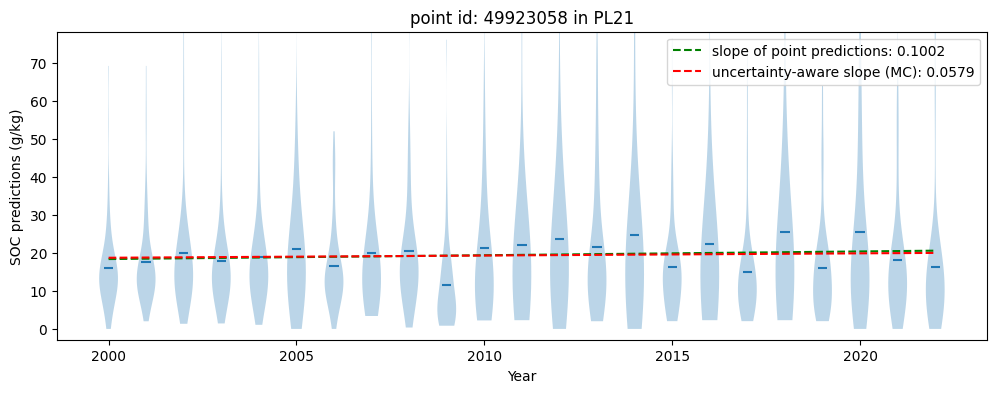

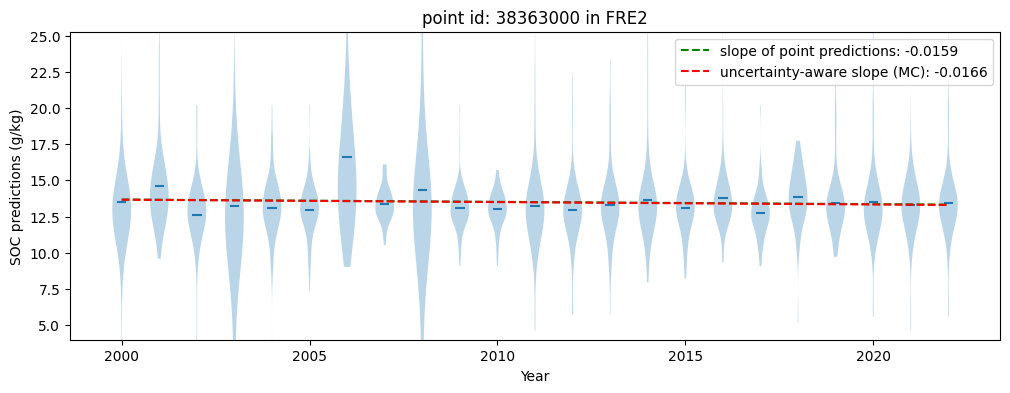

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import random
md = []
bd = []
mk = []
nutsl = []
for ii in [49923058,38363000]:#df['id'].unique(): #
    # print('id: ', ii)
    temp = df.loc[df['id']==ii]
    nuts = temp['nuts2'].values[0]
    nutsl.append(nuts)
    temp = temp.sort_values(by='year')
    
    t = np.array(temp['year'].values.tolist())-2000
    soc = np.array(temp['soc_pred'].values.tolist())
    dist = temp[dist_col].to_numpy()
    quantiles_list = [[0.025, 0.975]] * dist.shape[0]

    m, b = np.polyfit(t, soc, 1)
    mk.append(m)

    ml = []
    bl = []
    for i in range(1000):
        randn = random.randint(1, 64)
        ocp = np.array(temp[f'soc_s{randn}'].values.tolist())
        mp, bp = np.polyfit(t, ocp, 1)
        ml.append(mp)
        bl.append(bp)

    mm = np.mean(ml)
    bm = np.mean(bl)
    md.append(ml)
    bd.append(bl)
    
    ymax = np.quantile(dist,0.975)
    ymin = np.quantile(dist, 0.025)
    
    
    fig, ax = plt.subplots(figsize=(12,4))
    ax.violinplot(dataset=dist.T, positions=t+2000, showmeans=True, showextrema=False) #
    ax.plot(t+2000, m*t+b, '--g', label=f'slope of point predictions: {round(m,4)}') #t, soc, 'yo', 
    ax.plot(t+2000, mm*t+bm, '--r', label=f'uncertainty-aware slope (MC): {round(mm,4)}') #t, soc, 'yo', 
    ax.set_title(f'point id: {int(ii)} in {nuts}')
    ax.set_ylim([ymin-5,ymax+5])
    ax.set_ylabel('SOC predictions (g/kg)')
    ax.set_xlabel('Year')
    ax.legend()
    # ax.text(1999.5, np.max(dist)*0.85, f'\n')
    plt.show()

In [97]:
m_all = []
nutsl = []
mk = []
tryl = [20,100, 200, 1000, 2000, 10000, 20000]
for ii in [49923058,38363000]: #df['id'].unique(): #
    # print('id: ', ii)
    temp = df.loc[df['id']==ii]
    nuts = temp['nuts2'].values[0]
    nutsl.append(nuts)
    temp = temp.sort_values(by='year')
    
    t = np.array(temp['year'].values.tolist())-2000
    soc = np.array(temp['soc_pred'].values.tolist())
    dist = temp[dist_col].to_numpy()
    # quantiles_list = [[0.025, 0.975]] * dist.shape[0]

    m, b = np.polyfit(t, soc, 1)
    mk.append(m)

    mn = []
    
    for ir in tryl:
        ml = []
        bl = []
        for i in range(ir):
            randn = random.randint(1, 64)
            ocp = np.array(temp[f'soc_s{randn}'].values.tolist())
            mp, bp = np.polyfit(t, ocp, 1)
            ml.append(mp)
            bl.append(bp)
            
        mn.append(ml)
        
    m_all.append(mn)

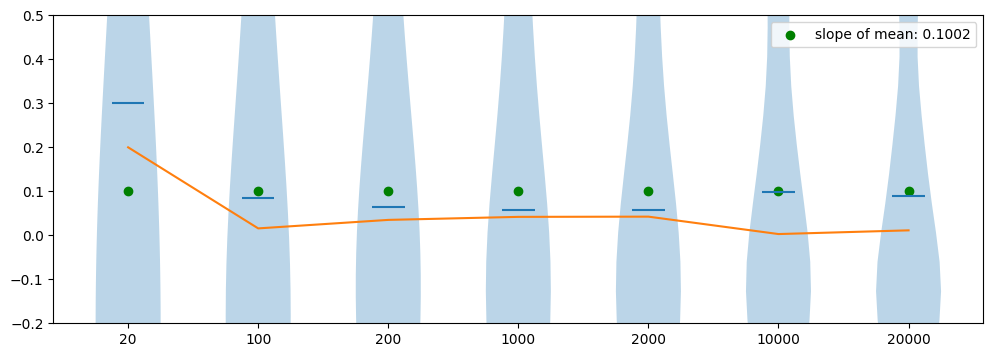

In [98]:
mn = m_all[0]
mn_mean = [np.mean(mn[iii]) for iii in range(len(tryl))]
mn_rsd = [abs(iii-mk[0]) for iii in mn_mean]

fig, ax = plt.subplots(figsize=(12,4))
ax.violinplot(mn, showmeans=True, showextrema=False) 
ax.scatter(list(range(1, len(tryl)+1)), [mk[0]]*len(tryl), label=f'slope of mean: {round(mk[0],4)}',color='green')
ax.set_xticks(list(range(1, len(tryl)+1)), labels=tryl)
ax.plot(list(range(1, len(tryl)+1)), mn_rsd)
ax.set_ylim([-0.2,0.5])
ax.legend()
plt.show()

## Trend uncertainty
### Distinguish between strong, confident trends and weak, uncertain trends with
- Trend Robustness Index (TRI): Proportion of ensemble realizations that agree on the trend direction (e.g., % of positive vs. negative slopes).
- Trend Uncertainty Spread (TUS): Width of the 95% confidence interval for the slopes. Wider intervals indicate less certainty.

### goals
- Identify regions or points with high trend uncertainty vs. robust trends.
- Discuss the implications of these findings for SOC monitoring and management.

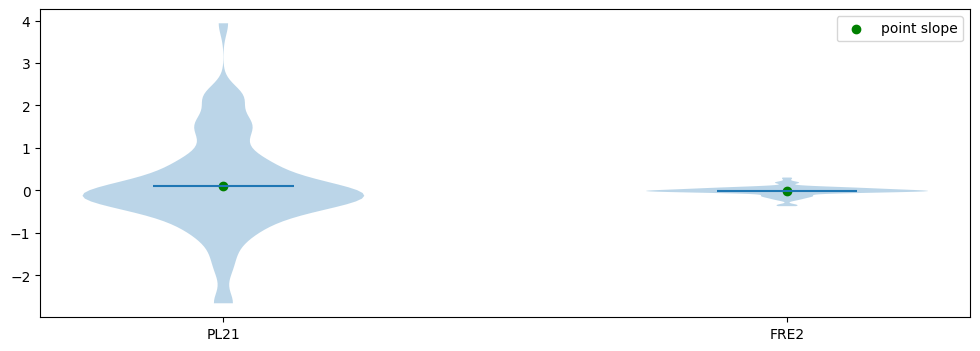

In [99]:
md = np.array(md)

fig, ax = plt.subplots(figsize=(12,4))
ax.violinplot(md.T, showmeans=True, showextrema=False) 
ax.scatter([1,2], mk, label='slope of point predicitons',color='green')
ax.set_xticks([1,2], labels=nutsl)
ax.legend()
plt.show()

In [43]:
mk

[0.10023056754010448, -0.0864509386507422, -0.015917840211287802]

## Bayesian model

In [40]:
import pymc as pm
import arviz as az

temp = df.loc[df['id']==49923058]
years = np.array(temp['year'].values.tolist())-2000
realization_cols = [col for col in temp.columns if col.startswith('soc_s')]
soc_realizations = temp[realization_cols].values  # Shape: (23 years, 64 realizations)

In [41]:
years_rep = np.repeat(years, soc_realizations.shape[1])
soc_values = soc_realizations.flatten()

# Step 2: Define the Bayesian Model
with pm.Model() as soc_trend_model:
    # Priors for intercept and slope
    alpha = pm.Normal('alpha', mu=15, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    
    # Prior for observation noise
    sigma = pm.HalfNormal('sigma', sigma=5)
    
    # Expected value of SOC
    mu = alpha + beta * years_rep
    
    # Likelihood (observed SOC realizations)
    soc_obs = pm.Normal('soc_obs', mu=mu, sigma=sigma, observed=soc_values)
    
    # Step 3: Run MCMC Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  18.370  1.176  16.230   20.652      0.021    0.015    3289.0    3617.0   
beta    0.101  0.092  -0.075    0.275      0.002    0.001    3343.0    3916.0   
sigma  23.465  0.422  22.668   24.260      0.006    0.004    4678.0    4016.0   

       r_hat  
alpha    1.0  
beta     1.0  
sigma    1.0  


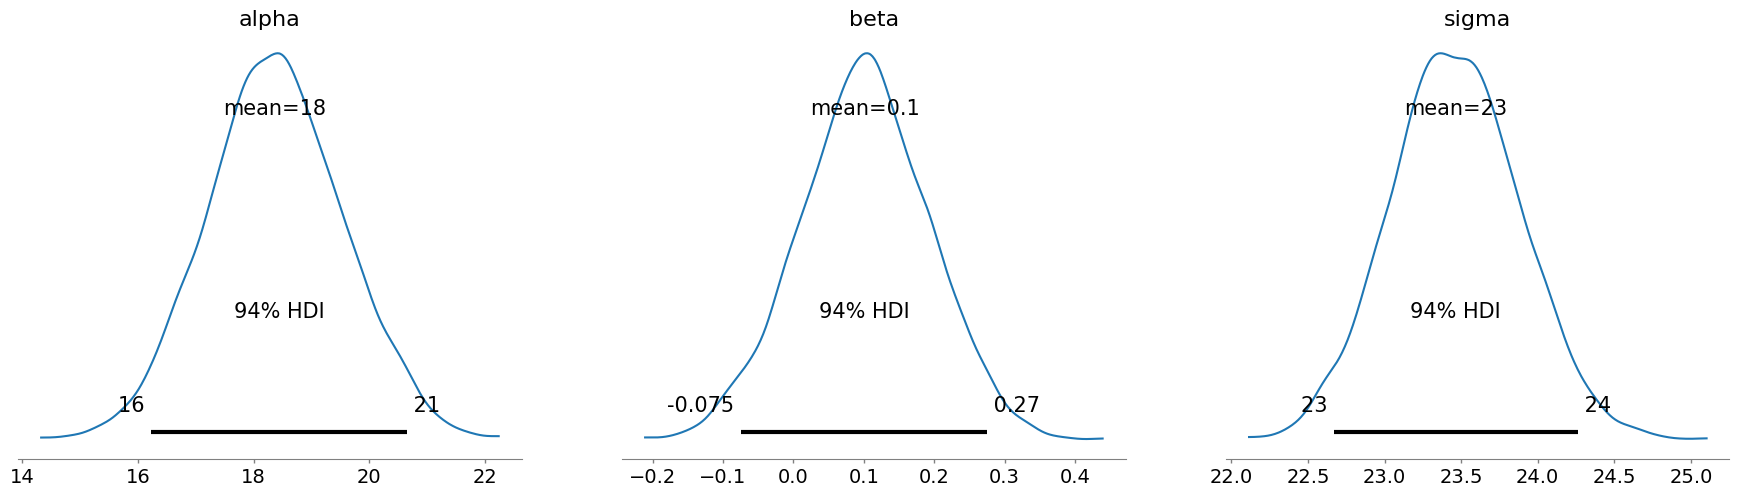

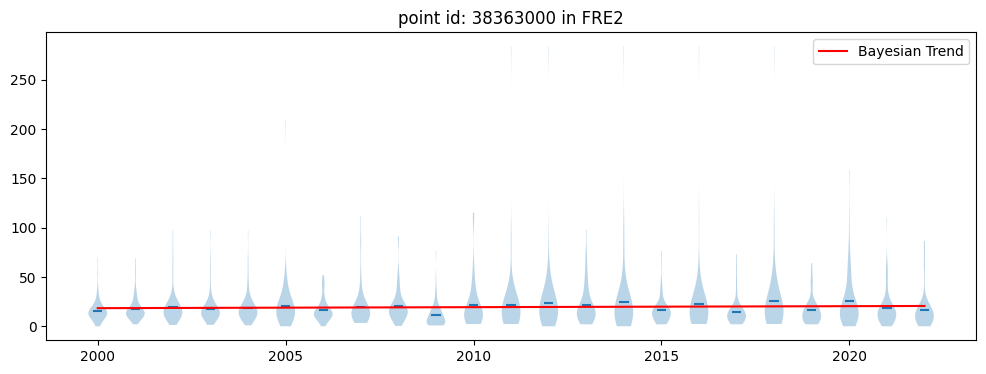

In [45]:
# Step 4: Analyze and Visualize Results

# Summary of the posterior
print(az.summary(trace, var_names=['alpha', 'beta', 'sigma']))

# Plot posterior distributions
az.plot_posterior(trace, var_names=['alpha', 'beta', 'sigma'])
plt.show()

# Plot the trend line with uncertainty
# Compute posterior predictive trend
alpha_post = trace.posterior['alpha'].mean().values
beta_post = trace.posterior['beta'].mean().values

fig, ax = plt.subplots(figsize=(12,4))
ax.violinplot(dataset=soc_realizations.T, positions=t+2000, showmeans=True, showextrema=False) #
plt.plot(years+2000, alpha_post + beta_post * years, label='Bayesian Trend', color='red')
ax.set_title(f'point id: {int(ii)} in {nuts}')
# ax.set_ylim([ymin-5,ymax+5])
ax.legend()
# ax.text(1999.5, np.max(dist)*0.85, f'\n')
plt.show()

# # Plot
# plt.figure(figsize=(10,6))
# for i in range(soc_realizations.shape[1]):
#     plt.plot(years, soc_realizations[:, i], color='gray', alpha=0.3)  # Plot realizations

# plt.plot(years+2000, temp['soc_pred'], 'o', label='Mean Prediction', color='blue')
# plt.xlabel('Year')
# plt.ylabel('SOC')
# plt.title('Bayesian Trend Estimation with Uncertainty')
# plt.legend()
# plt.show()

### interval-based
- Skew-Normal Resampling
- Bayesian Modeling with Informed Likelihood (Semi-Parametric Approach)
- quantile regression 

In [13]:
model = joblib.load(f'{output_folder}/model_rf.{prop}_ccc.joblib')
model.n_jobs = 90
model.fit(train[covs], train[tgt])


# tree predictions
tree_predictions = model.predict(test[covs])
y_pred = np.mean(tree_predictions, axis=0) # get the mean before transformation
y_pred = np.expm1(y_pred)

# calculate quantiles to form an accuracy plots
if space == 'log1p':
    tree_predictions = np.expm1(tree_predictions) # tranform before getting the percentile

quantiles = [0.005, 0.025, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.495, 0.5 , 0.505, 0.55,
             0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.975, 0.995]
y_q = np.percentile(tree_predictions, [q * 100 for q in quantiles], axis=0)
qcp = []
for ii in range(len(quantiles)):
    qcp.append(calc_qcp(y_q[ii], test[prop], quantiles[ii]))

# calculate piw, picp
pi = []
picp = []
piw_m = []
piw_med = []
for ii in range(12):
    jj = len(quantiles)-1-ii
    pi.append(round(1-quantiles[ii]*2,2))
    picp.append(calc_picp(y_q[ii,:], y_q[jj,:], test[prop]))
    piw_m.append(np.mean(y_q[jj,:]-y_q[ii,:]))
    piw_med.append(np.median(y_q[jj,:]-y_q[ii,:]))

# calculate PICP for target PI (+- 1 std): 68%, P16-P84
target_pi = [0.16, 0.84]
pib = np.percentile(tree_predictions, [q * 100 for q in target_pi], axis=0)
target_picp = calc_picp(pib[0], pib[1], test[prop])

Index(['bare.soil_mcd43a4.fc_m_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616',
       'CHELSA_gdgfgd10_1981-2010_V.2.1', 'CHELSA_vpd_max_1981-2010_V.2.1',
       'green_glad.landsat.ard2.seasconv.m.yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127',
       'CHELSA_gdd10_1981-2010_V.2.1',
       'fapar_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231218',
       'CHELSA_pr_10_1981-2010_V.2.1',
       'clm_accum.precipitation_chelsa.montlhy_m_1km_s0..0cm_YYYY.03.01..YYYY.03.31_v2.1',
       'CHELSA_vpd_range_1981-2010_V.2.1',
       'ndvi_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231127',
       'soil.moisture_s1.clms.qr.1.p0.95_m_1km_20140101_20241231_eu_epsg3035_v20250211',
       'CHELSA_ai_1981-2010_V.2.1',
       'wv_mcd19a2v061.seasconv.m.yearly_sd_1km_s_YYYY0101_YYYY1231_go_epsg.4326_v20230619',
       'CHELSA_bio15_1981-2010_V.2.1', 'lithology_egdi_prob_peat',
       'CHELSA_bio4_1981-2010_V.2.1', 